In [ ]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 16, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
kappa = 0.125
# dtype = torch.complex128
dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = clover.add_I(clover=clover_term)  # needed!
# clover_term = clover.add_I(clover=torch.zeros_like(clover_term))  # test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
U_eo = xxxtzyx2pxxxtzyx(input_array=U)
clover_eo = xxxtzyx2pxxxtzyx(input_array=clover_term)
verbose = True


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U_eo=U_eo,
                clover=clover, clover_eo=clover_eo, verbose=verbose)

self.dof_list:[12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
  Level 2: 4x4x4x4
  Level 3: 2x2x2x2
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8], [4, 4, 4, 4], [2, 2, 2, 2]]


In [3]:
_x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)


Performance Statistics:
Total iterations: 135
Total time: 4.215686 seconds
Average time per iteration: 0.031224 s
Final residual: 9.63e-07


In [4]:
x = mg.solve()


MG:Iteration 1:
x0 is just right!

MG:Iteration 2:
x0 is just right!

MG:Iteration 3:
x0 is just right!

MG:Iteration 4:
x0 is just right!

MG:Iteration 5:
x0 is just right!

MG:Iteration 6:
x0 is just right!

MG:Iteration 7:
x0 is just right!

Performance Statistics:
Total iterations: 7
Total time: 7.811955 seconds
Average time per iteration: 1.115896 s
Final residual: 9.90e-07


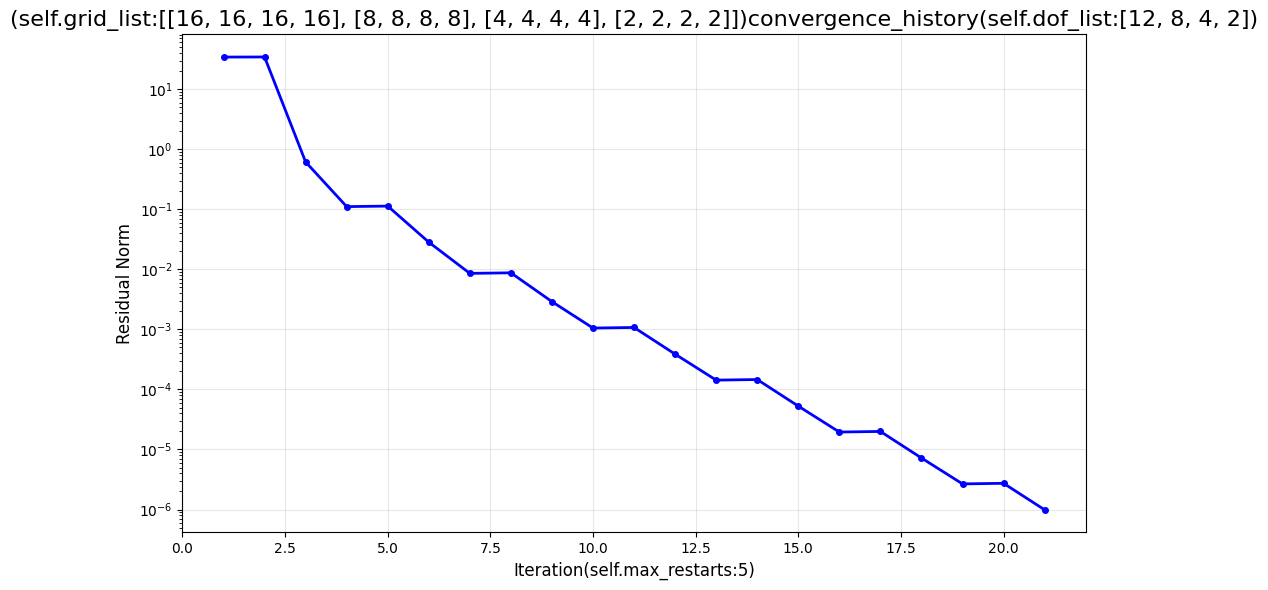

In [5]:
mg.plot()

In [8]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

1.0


In [10]:
_x

tensor([[[[[[ 4.2362e-01-1.5848e-01j, -1.1921e+00-2.2154e-01j,
             -1.0872e+00+8.2834e-01j,  ...,
              4.8023e-01+5.4459e-02j,  1.2516e+00-1.4322e-01j,
             -3.1543e-01-3.0423e-01j],
            [-1.3689e+00-2.8604e-01j, -5.7475e-01-4.3125e-01j,
             -1.1440e-01+5.4396e-01j,  ...,
              7.7262e-01+5.5071e-01j, -1.3390e-01+1.0746e+00j,
              2.6787e-02+7.6056e-01j],
            [ 4.8641e-01-1.5195e+00j,  6.0213e-01-8.8128e-02j,
              7.3227e-01-2.1742e-01j,  ...,
              2.9643e-01+7.0048e-02j, -1.0527e+00-6.6831e-01j,
             -2.3305e-01-1.0802e+00j],
            ...,
            [-1.9568e-01+4.3399e-03j, -6.0623e-01+5.3975e-01j,
              9.1884e-01+4.1087e-01j,  ...,
              4.6618e-01-8.7832e-01j,  2.0588e+00-5.7207e-01j,
              1.3762e-01+1.1201e+00j],
            [ 2.3815e-01-4.3121e-01j,  3.6768e-01+6.2922e-01j,
             -2.6750e-01+7.1166e-01j,  ...,
             -3.9223e-01-1.4597e-01j,  3